In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS

In [2]:
with duckdb.connect(database='../data/propensity_to_buy.duckdb', read_only=True) as con:
    # print(con.sql('SHOW TABLES;'))
    sales_df = con.sql("SELECT * FROM sales;").df()

display(sales_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   lead_id                    50000 non-null  int64         
 1   lead_entry_time            50000 non-null  datetime64[us]
 2   has_placed_order           50000 non-null  bool          
 3   time_order_placed          6500 non-null   datetime64[us]
 4   salary                     49750 non-null  float64       
 5   date_of_birth              50000 non-null  datetime64[us]
 6   postcode                   49750 non-null  object        
 7   n_engaged_minutes          49750 non-null  float64       
 8   n_of_cars_viewed           50000 non-null  int64         
 9   company_industry           49750 non-null  object        
 10  day_of_week                50000 non-null  int64         
 11  price_of_last_car_viewed   50000 non-null  float64       
 12  step

None

In [3]:
sales_df.sample(5)

lead_id            lead_entry_time  has_placed_order time_order_placed  \
33156    43156 2024-09-16 16:33:18.792278             False               NaT   
41978    51978 2024-07-25 11:42:16.573536             False               NaT   
35283    45283 2025-05-15 03:11:18.677071             False               NaT   
31928    41928 2025-07-08 04:15:03.752761             False               NaT   
35439    45439 2024-11-29 15:44:39.261100             False               NaT   

         salary date_of_birth postcode  n_engaged_minutes  n_of_cars_viewed  \
33156  59139.77    1976-05-16   W0 3UD              17.60                 0   
41978  54595.46    1971-07-28  L1C 0DN              26.41                 2   
35283  89801.75    1979-04-14  L6D 5NY              14.69                 5   
31928  62733.03    1984-02-17   W5 1SS              17.50                13   
35439   3530.40    1985-05-28   B7 5LS              13.88                 1   

                       company_industry  day_of_week  \
33156  engineer proactive relationships            0   
41978     utilize cross-media paradigms            3   
35283           grow back-end synergies            3   
31928       iterate efficient platforms            1   
35439    facilitate proactive bandwidth            4   

       price_of_last_car_viewed step_reached_in_website  \
33156                    447.16                homepage   
41978                    456.68          car_configured   
35283                    484.33          car_configured   
31928                    358.29             car_clicked   
35439                    510.18          car_configured   

      how_did_you_hear_about_us  
33156      company benefit page  
41978                    google  
35283                  linkedin  
31928                     other  
35439                     other

In [4]:
sales_df['lead_id'].nunique()

50000

# insight #1: 
number of unique lead ids matched the count of records in the table. that means every record of the sales table as a unique lead id, no lead occurs multiple times, meaning:
1. no one has both been tagged as both a purchaser and as non-purchaser
2. and no lead has multiple purchase records to their name

(don't need to consider repeat customers) 

now we check out the outcome variable.

has_placed_order
False    43500
True      6500
Name: count, dtype: int64

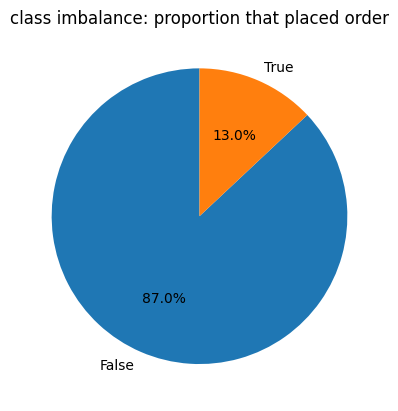

In [5]:
display(sales_df.value_counts('has_placed_order'))
(
    sales_df
    .value_counts('has_placed_order')
    .plot(
        kind='pie',
        # y='has_placed_order',
        title="class imbalance: proportion that placed order",
        ylabel='',
        legend=False,
        autopct='%1.1f%%',
        shadow=False,
        startangle=90
    )
)
plt.show()

# insight #2
about 1/8th of the leads made a (single) purchase.

In [6]:
sales_df.describe()

lead_id             lead_entry_time           time_order_placed  \
count  50000.000000                       50000                        6500   
mean   34999.500000  2025-01-23 14:16:26.200589  2025-02-02 13:48:39.111401   
min    10000.000000  2024-07-25 03:29:16.591643  2024-07-26 17:20:10.840381   
25%    22499.750000  2024-10-24 02:20:40.822838  2024-11-02 02:31:11.248647   
50%    34999.500000  2025-01-23 02:38:18.746192  2025-02-03 12:35:14.406815   
75%    47499.250000  2025-04-24 22:44:13.972722  2025-05-05 12:41:59.751895   
max    59999.000000  2025-07-25 08:53:49.249868  2025-12-22 06:14:14.475609   
std    14433.901067                         NaN                         NaN   

              salary               date_of_birth  n_engaged_minutes  \
count   49750.000000                       50000       49750.000000   
mean    56682.833271  1978-02-08 22:24:54.144000          20.094337   
min    -20090.360000         1951-07-26 00:00:00           0.000000   
25%     41802.375000         1964-12-02 00:00:00           9.520000   
50%     56004.750000         1978-02-23 12:00:00          16.695000   
75%     71022.332500         1991-04-14 06:00:00          26.710000   
max    598374.160000         2004-07-24 00:00:00        2783.850000   
std     22145.773858                         NaN          27.586101   

       n_of_cars_viewed   day_of_week  price_of_last_car_viewed  
count      50000.000000  50000.000000              50000.000000  
mean           4.518260      2.998660                450.299871  
min            0.000000      0.000000                239.310000  
25%            0.000000      1.000000                416.480000  
50%            3.000000      3.000000                450.220000  
75%            9.000000      5.000000                484.100000  
max           14.000000      6.000000                647.660000  
std            4.831395      1.994838                 49.956064

# insight #3
leads can register negative salaries. 
a lead's salary is logically expected to be a factor in their propensity to purchase, but how negative incomes are to be interpreted ins uncertain. and how does that affect feature engineering of the income column? (standarisation and normalisation).

also, salaries and number of engaged minutes are two columns with missing values. (time when order placed has as many populated cells as there are purchases, so no more values are expected in that field).

In [7]:
ordered_only = (
    sales_df[
        sales_df['has_placed_order']
    ]
    .assign(weekday_num_ordered  = sales_df['time_order_placed'].dt.day_of_week)
    .assign(day_of_week_ordered  = sales_df['time_order_placed'].dt.day_name())
    .assign(hour_of_day_ordered  = sales_df['time_order_placed'].dt.hour)
    .assign(entry_order_gap_hrs  =(sales_df['time_order_placed']-sales_df['lead_entry_time']).dt.seconds/3600)
    .assign(age_at_time_of_order =(sales_df['time_order_placed']-sales_df['date_of_birth']).dt.days/365.25)
)
ordered_only.sample(3)

lead_id            lead_entry_time  has_placed_order  \
662      10662 2024-10-18 13:58:31.209564              True   
46460    56460 2025-06-18 10:51:20.444947              True   
48571    58571 2025-06-05 02:11:10.549502              True   

               time_order_placed    salary date_of_birth  postcode  \
662   2024-11-24 11:05:25.457630  53318.88    1977-05-20  TN9X 0AN   
46460 2025-06-19 09:23:44.454838  80218.33    1998-01-25    N5 1LZ   
48571 2025-06-07 17:20:18.270746  57741.57    1970-04-14   WD9 6GZ   

       n_engaged_minutes  n_of_cars_viewed  \
662                  NaN                12   
46460              27.82                 0   
48571               3.91                11   

                          company_industry  day_of_week  \
662                            Real Estate            4   
46460        transition sticky communities            2   
48571  e-enable revolutionary web services            3   

       price_of_last_car_viewed step_reached_in_website  \
662                      452.24          car_configured   
46460                    344.74                homepage   
48571                    403.99          car_configured   

      how_did_you_hear_about_us  weekday_num_ordered day_of_week_ordered  \
662                       other                  6.0              Sunday   
46460                    google                  3.0            Thursday   
48571                    google                  5.0            Saturday   

       hour_of_day_ordered  entry_order_gap_hrs  age_at_time_of_order  
662                   11.0            21.115000             47.515400  
46460                  9.0            22.540000             27.397673  
48571                 17.0            15.151944             55.148528

In [8]:
ordered_only.describe()

lead_id             lead_entry_time           time_order_placed  \
count   6500.000000                        6500                        6500   
mean   35341.132462  2025-01-25 07:25:40.015586  2025-02-02 13:48:39.111401   
min    10004.000000  2024-07-25 07:01:44.142734  2024-07-26 17:20:10.840381   
25%    22847.500000  2024-10-25 14:39:06.131295  2024-11-02 02:31:11.248647   
50%    35492.500000  2025-01-25 17:27:29.689367  2025-02-03 12:35:14.406815   
75%    47822.000000  2025-04-28 01:44:12.746109  2025-05-05 12:41:59.751895   
max    59996.000000  2025-07-25 08:29:50.864110  2025-12-22 06:14:14.475609   
std    14424.470158                         NaN                         NaN   

              salary               date_of_birth  n_engaged_minutes  \
count    6467.000000                        6500        6456.000000   
mean    76352.192338  1975-03-23 00:23:55.569230          24.758067   
min      7620.590000         1951-07-26 00:00:00           0.000000   
25%     65215.850000         1962-02-18 18:00:00          12.440000   
50%     76042.990000         1973-12-19 12:00:00          21.255000   
75%     87297.625000         1987-10-10 00:00:00          33.615000   
max    146734.880000         2004-07-14 00:00:00         139.160000   
std     16628.152491                         NaN          16.567249   

       n_of_cars_viewed  day_of_week  price_of_last_car_viewed  \
count       6500.000000  6500.000000               6500.000000   
mean           6.602154     3.057538                450.295138   
min            0.000000     0.000000                284.700000   
25%            2.000000     1.000000                416.572500   
50%            7.000000     3.000000                449.860000   
75%           11.000000     5.000000                484.402500   
max           14.000000     6.000000                616.320000   
std            4.789252     1.975324                 49.614309   

       weekday_num_ordered  hour_of_day_ordered  entry_order_gap_hrs  \
count          6500.000000          6500.000000          6500.000000   
mean              2.986923            11.317846            12.301711   
min               0.000000             0.000000             0.000556   
25%               1.000000             5.000000             6.441111   
50%               3.000000            11.000000            12.372500   
75%               5.000000            17.000000            18.251458   
max               6.000000            23.000000            23.995278   
std               2.007828             6.857745             6.880807   

       age_at_time_of_order  
count           6500.000000  
mean              49.867396  
min               20.199863  
25%               37.321697  
50%               51.133470  
75%               62.963039  
max               73.924709  
std               15.067984

In [9]:
ordered_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 4 to 49996
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   lead_id                    6500 non-null   int64         
 1   lead_entry_time            6500 non-null   datetime64[us]
 2   has_placed_order           6500 non-null   bool          
 3   time_order_placed          6500 non-null   datetime64[us]
 4   salary                     6467 non-null   float64       
 5   date_of_birth              6500 non-null   datetime64[us]
 6   postcode                   6473 non-null   object        
 7   n_engaged_minutes          6456 non-null   float64       
 8   n_of_cars_viewed           6500 non-null   int64         
 9   company_industry           6465 non-null   object        
 10  day_of_week                6500 non-null   int64         
 11  price_of_last_car_viewed   6500 non-null   float64       
 12  step_reach

In [10]:
unconverted_only = sales_df[~sales_df['has_placed_order']]
unconverted_only.describe()

lead_id             lead_entry_time time_order_placed  \
count  43500.000000                       43500                 0   
mean   34948.451471  2025-01-23 08:07:28.274211               NaT   
min    10000.000000  2024-07-25 03:29:16.591643               NaT   
25%    22439.750000  2024-10-23 20:22:45.838636               NaT   
50%    34935.500000  2025-01-22 15:23:52.126135               NaT   
75%    47439.250000  2025-04-24 14:35:20.943089               NaT   
max    59999.000000  2025-07-25 08:53:49.249868               NaT   
std    14434.781106                         NaN               NaN   

              salary               date_of_birth  n_engaged_minutes  \
count   43283.000000                       43500       43294.000000   
mean    53743.994810  1978-07-16 09:58:50.482758          19.398882   
min    -20090.360000         1951-07-26 00:00:00           0.010000   
25%     39681.260000         1965-06-20 00:00:00           9.220000   
50%     52983.060000         1978-10-24 00:00:00          16.100000   
75%     66789.315000         1991-09-17 00:00:00          25.787500   
max    598374.160000         2004-07-24 00:00:00        2783.850000   
std     21353.319018                         NaN          28.806659   

       n_of_cars_viewed   day_of_week  price_of_last_car_viewed  
count      43500.000000  43500.000000              43500.000000  
mean           4.206874      2.989862                450.300578  
min            0.000000      0.000000                239.310000  
25%            0.000000      1.000000                416.470000  
50%            2.000000      3.000000                450.290000  
75%            8.000000      5.000000                484.052500  
max           14.000000      6.000000                647.660000  
std            4.760001      1.997611                 50.007497

# insight #4
average salary of purchasers significantly higher (£76k) than the overall population (£57k) and especially higher than the average salary of the unconverted population (£53k).


In [11]:
sales_df.value_counts('day_of_week').sort_index()

day_of_week
0    7144
1    7017
2    7208
3    7288
4    7208
5    7006
6    7129
Name: count, dtype: int64

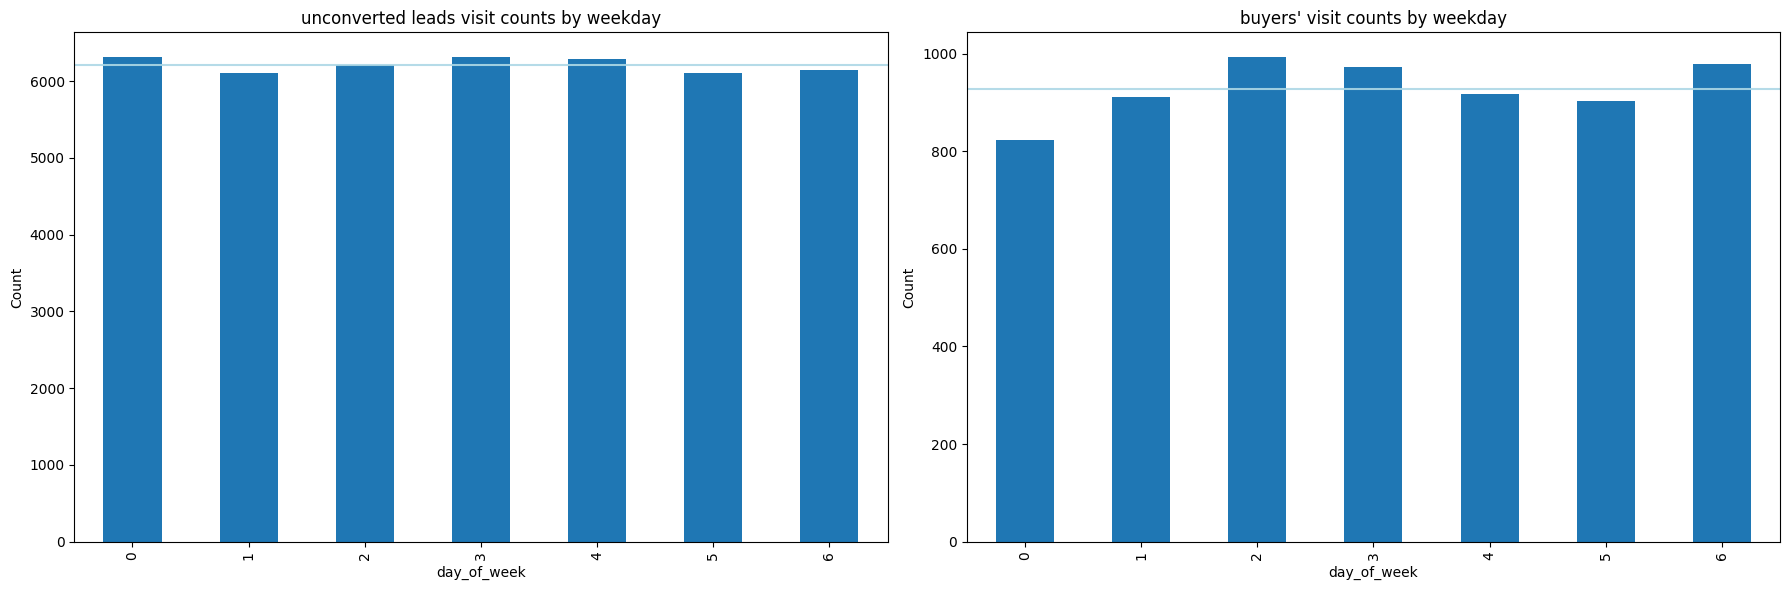

In [12]:
# Create a figure with 1 row and 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
unconverted_only.value_counts('day_of_week').sort_index().plot(
    kind='bar',
    title="unconverted leads visit counts by weekday",
    ylabel='Count',
    legend=False,
    ax=ax1 
)
average_visit_counts = unconverted_only.value_counts('day_of_week').mean()
ax1.axhline(
    y=average_visit_counts,
    color='lightblue',
    linestyle='-', 
    alpha=0.9, 
    label=f'avg: {average_visit_counts:.1f}'
)
ordered_only.value_counts('day_of_week').sort_index().plot(
    kind='bar',
    title="buyers' visit counts by weekday", 
    ylabel='Count',
    legend=False,
    ax=ax2  # Specify which subplot to use
)
average_visit_counts = ordered_only.value_counts('day_of_week').mean()
ax2.axhline(
    y=average_visit_counts,
    color='lightblue',
    linestyle='-', 
    alpha=0.9, 
    label=f'avg: {average_visit_counts:.1f}'
)

plt.tight_layout()
plt.show()

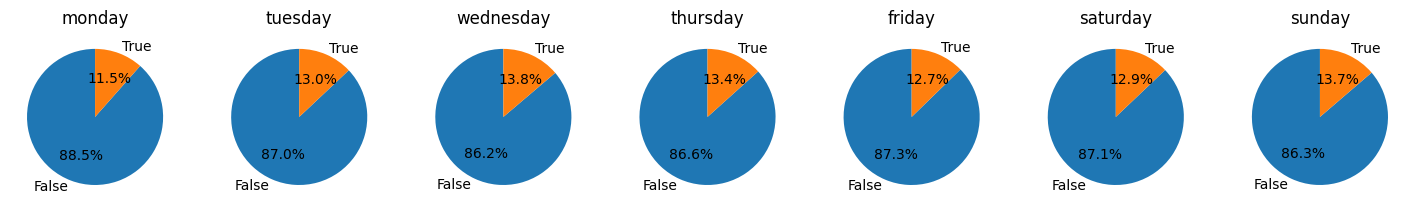

In [13]:
# a figure with 1 row and 7 columns of subplots
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(18, 4))
ax_tuple = (ax1, ax2, ax3, ax4, ax5, ax6, ax7)
# note! does not follow the iso-8601 weekday numbering
weekday_name = {
    0:'monday',
    1:'tuesday',
    2:'wednesday',
    3:'thursday',
    4:'friday',
    5:'saturday',
    6:'sunday'
}
    
for weekday_num in range(0,7):
    weekday_visits = sales_df[sales_df['day_of_week']==weekday_num]
    (
        weekday_visits
        .value_counts('has_placed_order')
        .plot(
            kind='pie',
            title=weekday_name.get(weekday_num),
            ylabel='',
            autopct='%1.1f%%',
            legend=False,
            shadow=False,
            startangle=90, 
            ax=ax_tuple[weekday_num]
        )
    )      

# insight #4
- for non-buyers, the day of week has a fairly flat, close to uniform distribution.
- for the buyers, there is a marked difference between the low volume on monday (weekday=0) and higher than daily average counts on wednesday-thursday and sunday.
- the overall propensity to buy ranges from 11.5% for lead entry on a monday to 13.8% on a wednesday. (yet to test whether the difference is statistically significant but a delta of 100 on counts of 1000 is convincing).

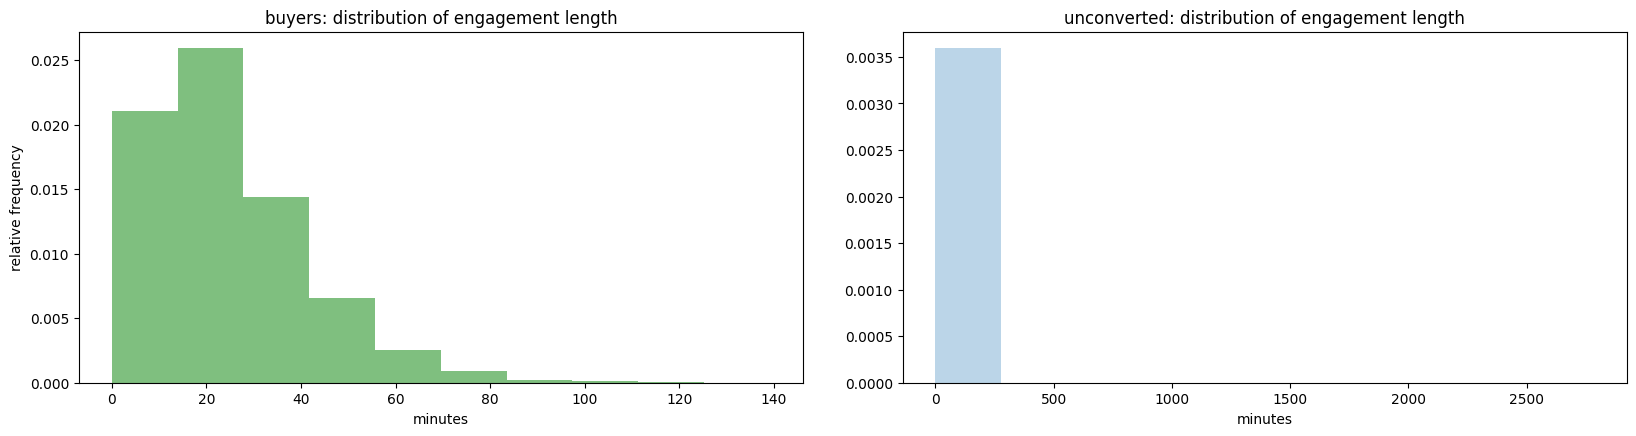

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
(
    ordered_only
    ['n_engaged_minutes']
    .plot
    .hist(
        title='buyers: distribution of engagement length',
        alpha=0.5,
        density=True,
        ylabel='relative frequency',
        xlabel='minutes',
        color='green',
        ax=ax1
    )
)

(
    unconverted_only
    ['n_engaged_minutes']
    .plot
    .hist(
        title='unconverted: distribution of engagement length',
        alpha=0.3,
        density=True,
        ax=ax2,
        ylabel='',
        xlabel='minutes'
    )
)

fig.tight_layout(pad = 3) 
plt.show()

# insight #5
some data quality issues to be clarified on the length of sessions. 2500 minutes is an implausible session length. someone fell asleep at the mouse? more likely session end event failed to be recorded, browser crashed or something. skip session longer than three hours

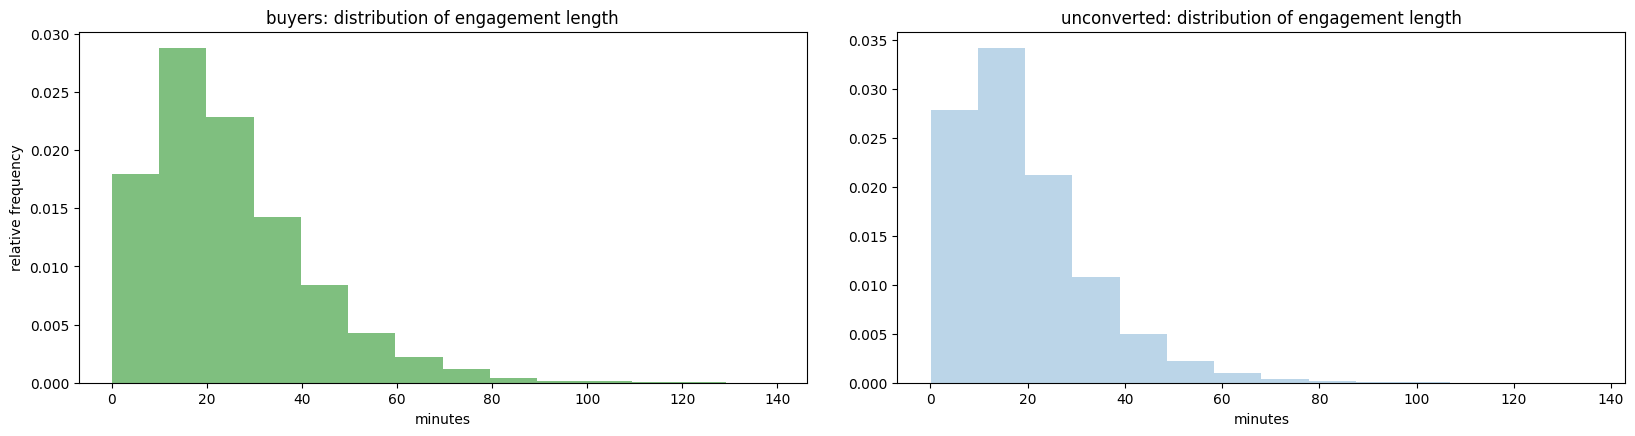

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
(
    ordered_only
    ['n_engaged_minutes']
    .plot
    .hist(
        title='buyers: distribution of engagement length',
        alpha=0.5,
        density=True,
        ylabel='relative frequency',
        xlabel='minutes',
        color='green',
        bins=14,
        ax=ax1
    )
)

(
    unconverted_only[
        unconverted_only['n_engaged_minutes']<180
    ]
    ['n_engaged_minutes']
    .plot
    .hist(
        title='unconverted: distribution of engagement length',
        alpha=0.3,
        density=True,
        ylabel='',
        xlabel='minutes',
        bins=14,
        ax=ax2
    )
)

fig.tight_layout(pad = 3) 
plt.show()

outside of clearly erroneous session lengths, 2 hours 20 minutes is the maximum time spent.
buyers genereally less likely to spend 10 minutes or less than unconverted. compared to non buyers, more buyers spend between 20 and 30 minutes on the site.

let's drill down on session taking less than 1 hour:

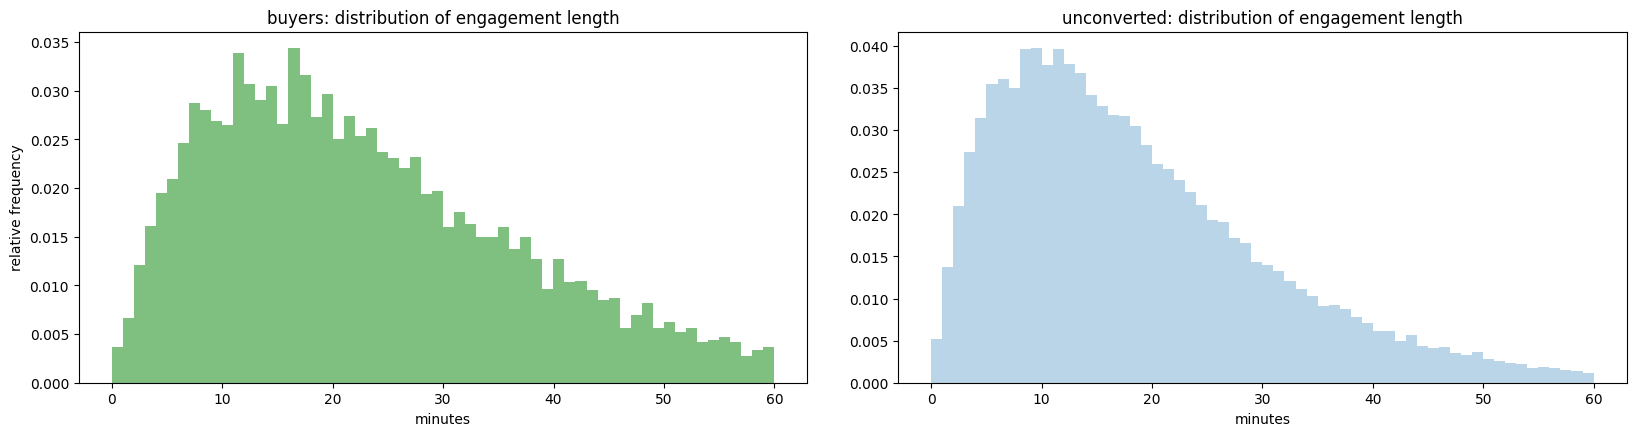

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
(
    ordered_only[
        ordered_only['n_engaged_minutes']<60
    ]
    ['n_engaged_minutes']
    .plot
    .hist(
        title='buyers: distribution of engagement length',
        alpha=0.5,
        density=True,
        ylabel='relative frequency',
        xlabel='minutes',
        color='green',
        bins=60,
        ax=ax1
    )
)

(
    unconverted_only[
        unconverted_only['n_engaged_minutes']<60
    ]
    ['n_engaged_minutes']
    .plot
    .hist(
        title='unconverted: distribution of engagement length',
        alpha=0.3,
        density=True,
        ylabel='',
        xlabel='minutes',
        bins=60,
        ax=ax2
    )
)

fig.tight_layout(pad = 3) 
plt.show()

ok. i am not seeing any particularly obvious minimum session length likelier to end in a conversion.

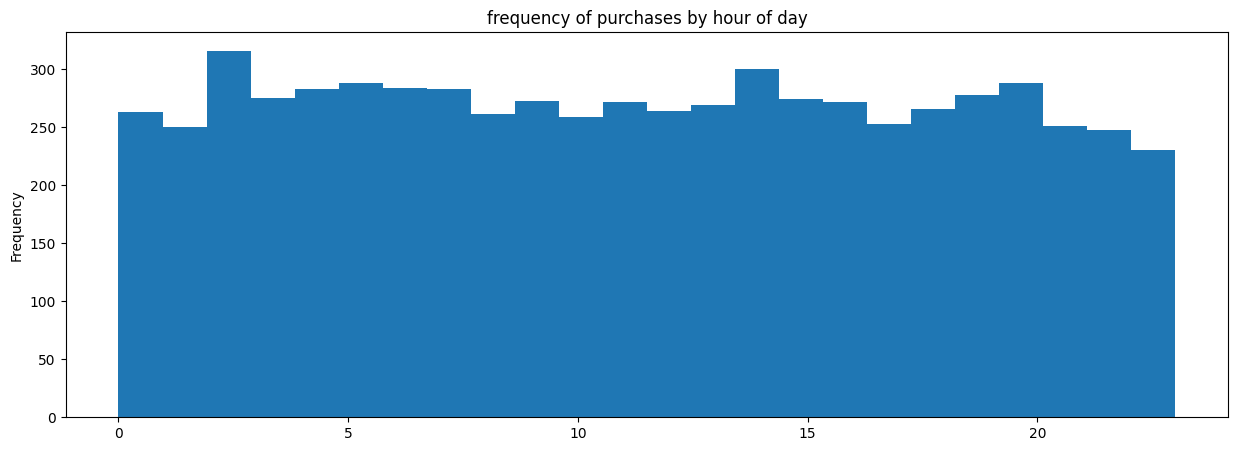

In [17]:
plt.figure(figsize=(15,5))
ordered_only['hour_of_day_ordered'].plot.hist(bins=24, title='frequency of purchases by hour of day')   
plt.show()

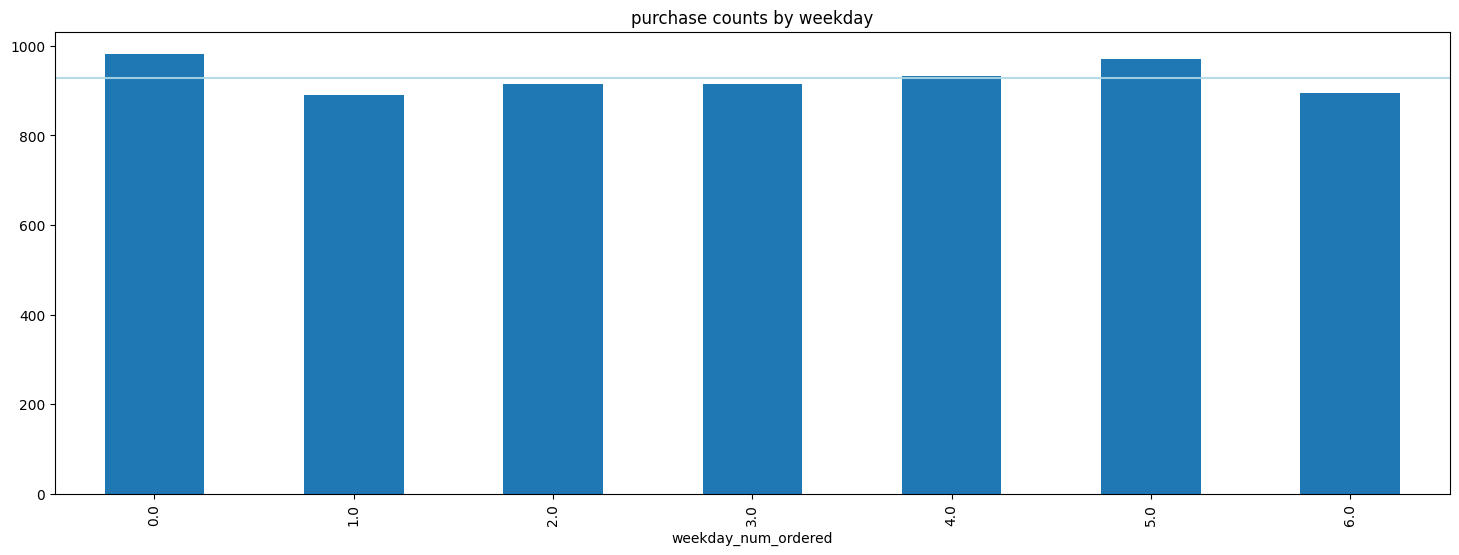

In [18]:
plt.figure(figsize=(18, 6))
(
    ordered_only['weekday_num_ordered']
    .value_counts()
    .sort_index()
    .plot(
        kind='bar',
        title='purchase counts by weekday',
        legend=False,
    )
)

average_visit_counts = ordered_only.value_counts('weekday_num_ordered').mean()
plt.axhline(
    y=average_visit_counts,
    color='lightblue',
    linestyle='-', 
    alpha=0.9, 
    label=f'avg: {average_visit_counts:.1f}'
)

# location, location, location

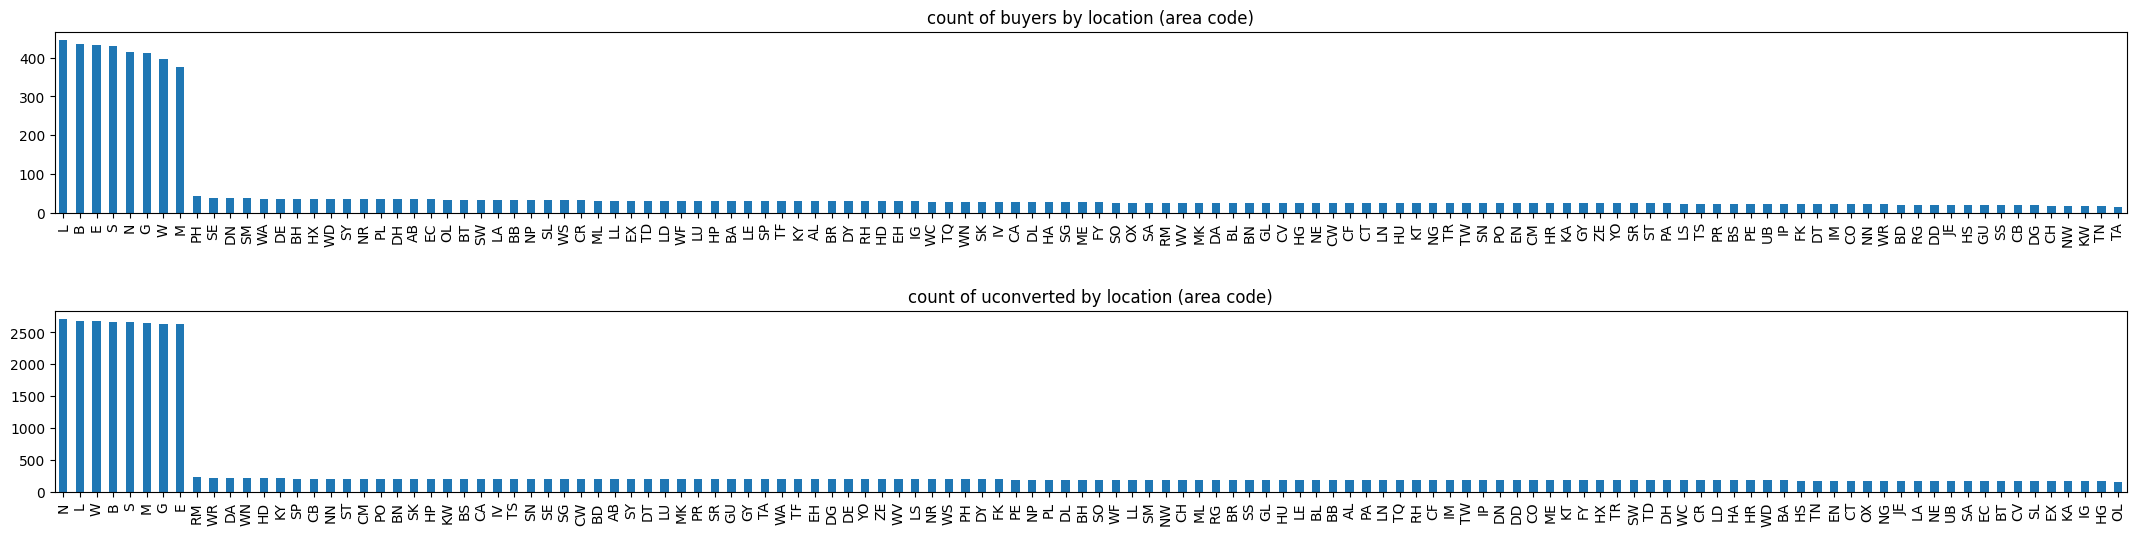

In [19]:
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(22, 6))
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 5))
# plt.figure(figsize=(20,6)) 
# (
#     sales_df
#     .assign(location = sales_df['postcode'].str.extract(r'(.*?)\d')) # get the first (non-numerical) component of the post code
#     .value_counts('location')
#     .plot(
#         kind='bar',
#         title='count of all leads by location (area code)',
#         xlabel='',
#         ax=ax1
#     )
# )
(
    ordered_only
    .assign(location = sales_df['postcode'].str.extract(r'(.*?)\d'))
    .value_counts('location')
    .plot(
        kind='bar',
        title='count of buyers by location (area code)',
        xlabel='',
        ax=ax2
    )
)
(
    unconverted_only
    .assign(location = sales_df['postcode'].str.extract(r'(.*?)\d'))
    .value_counts('location')
    .plot(
        kind='bar',
        title='count of uconverted by location (area code)',
        xlabel='',
        ax=ax3
    )
)
fig.tight_layout(pad = 3) 
plt.show()

not sure that there are any relevant or statistically significant differences in the numbers from each of the big area codes (N and E). would need to calculate the proportions of leads from each area to see likelihood of purchase by area. in any event this is a super high cardinality categorical variable. will need to map into fewer categories. 


<Axes: xlabel='n_of_cars_viewed'>

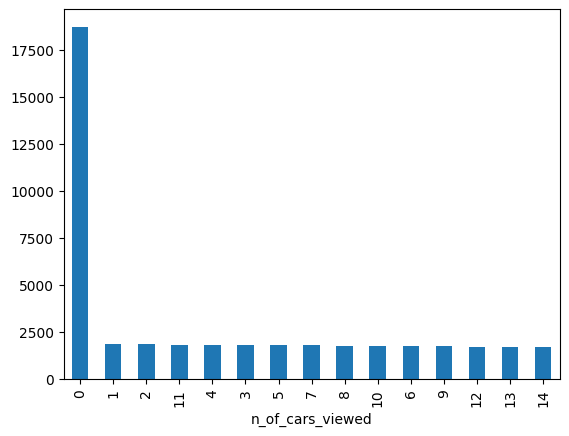

In [20]:
unconverted_only['n_of_cars_viewed'].value_counts().sort_values(ascending=False).plot.bar()

<Axes: xlabel='n_of_cars_viewed'>

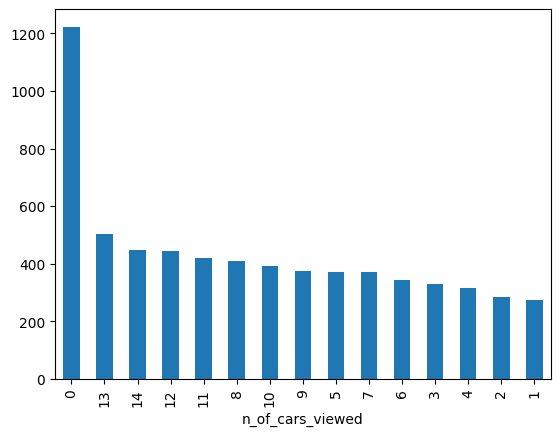

In [21]:
ordered_only['n_of_cars_viewed'].value_counts().sort_values(ascending=False).plot.bar()

as could be guessed, buyers are more likely to view a number of cars (>10).

# industries

In [22]:
# get a sense of the industry keywords in the data set
' '.join(sales_df['company_industry'].fillna('').sort_values().unique())

' Automotive Consulting Education Finance Government Healthcare Manufacturing Real Estate Retail Tech benchmark cutting-edge e-services brand visionary relationships cultivate enterprise deliverables cultivate global infrastructures deliver collaborative portals deploy leading-edge niches e-enable interactive eyeballs e-enable revolutionary web services embrace rich models empower distributed e-services engineer proactive relationships facilitate efficient infrastructures facilitate end-to-end paradigms facilitate proactive bandwidth generate global e-business generate virtual e-commerce grow back-end synergies implement dot-com content implement frictionless eyeballs implement next-generation e-services incubate dynamic e-tailers innovate cutting-edge functionalities integrate enterprise technologies iterate efficient platforms leverage integrated action-items leverage strategic action-items matrix bricks-and-clicks e-tailers mesh robust partnerships monetize value-added supply-chains

well. that's largely gibberish.

there are 60 company industries


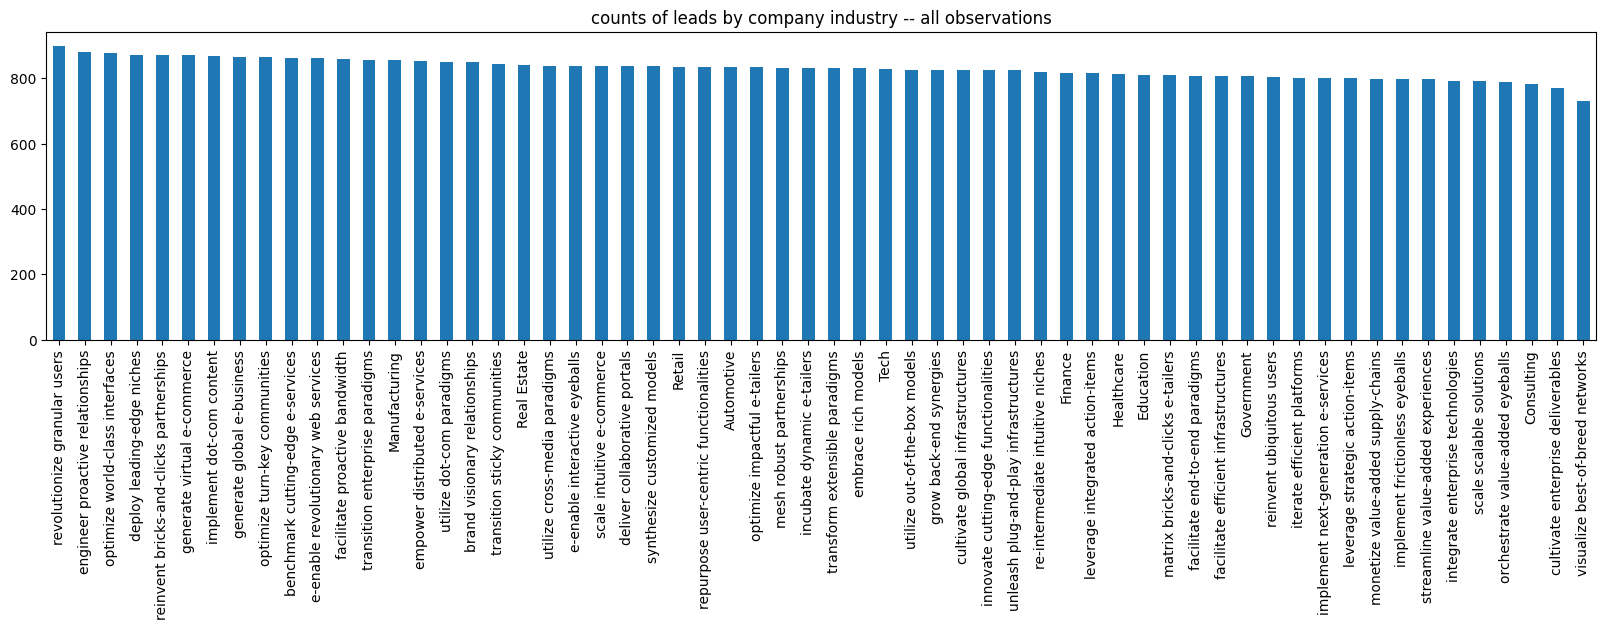

In [23]:
print('there are', sales_df['company_industry'].nunique(), 'company industries')
plt.figure(figsize=(20,4))
(
    # ordered_only['company_industry']
    # unconverted_only['company_industry']
    sales_df['company_industry']
    .value_counts()
    .sort_values(ascending=False)
    .plot
    .bar(
        title='counts of leads by company industry -- all observations',
        xlabel=''
    )
)
plt.show()

60 is a pretty high cardinality of the categorical variable. doing a one hot encoding on that field will lead to high dimensionality and sparse matrices. can drop or condense these down.  

In [24]:
# save a copy for offline reviewing.
(
    sales_df['company_industry']
    .value_counts()
    .sort_values(ascending=False)
    .to_csv('../data/company_industries.csv')
)

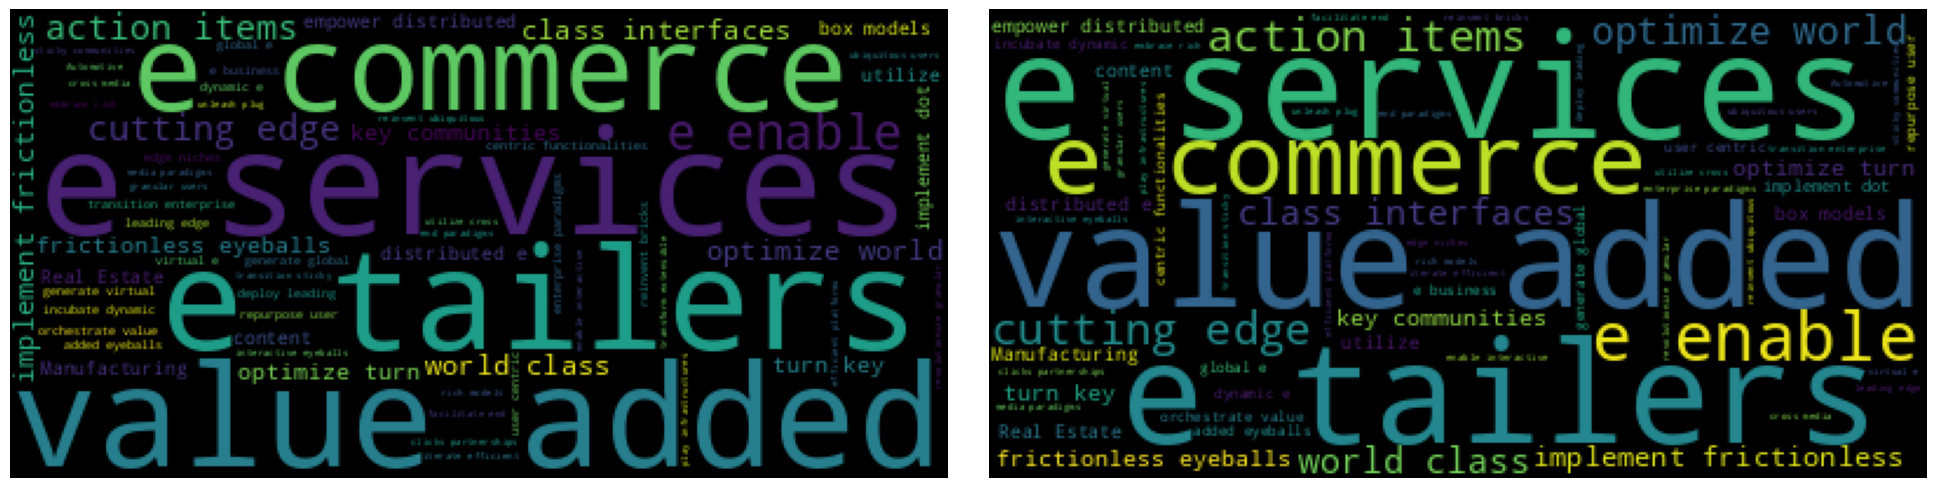

In [25]:
# maybe industries differ among the buyer and non-buyer populations?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), facecolor=None)

wordcloud = WordCloud().generate(' '.join(ordered_only['company_industry'].fillna('')))
ax1.imshow(wordcloud) 
ax1.axis("off") 

wordcloud = WordCloud().generate(' '.join(ordered_only['company_industry'].fillna('')))
ax2.imshow(wordcloud) 
ax2.axis("off") 

fig.tight_layout(pad = 3) 
# fig.title('ordered    --  nonconverted')
plt.show() 

In [26]:
# (
#     ordered_only
#     .groupby(by=['company_industry'], observed=True)
#     .agg({'lead_id':'count'})
#     .sort_values('lead_id', ascending=False)
#     .head(10)
# )
(
    unconverted_only
    .groupby(by=['company_industry'], observed=True)
    .agg({'lead_id':'count'})
    .sort_values('lead_id', ascending=False)
    .head(10)
)

lead_id
company_industry                                
revolutionize granular users                 786
engineer proactive relationships             785
facilitate proactive bandwidth               762
benchmark cutting-edge e-services            760
e-enable revolutionary web services          756
reinvent bricks-and-clicks partnerships      755
deploy leading-edge niches                   753
generate virtual e-commerce                  753
brand visionary relationships                752
generate global e-business                   748

# insight #
- no obvious differences spotted between buyers and the unconverted when it comes to the industry key words.

conversion rate from source


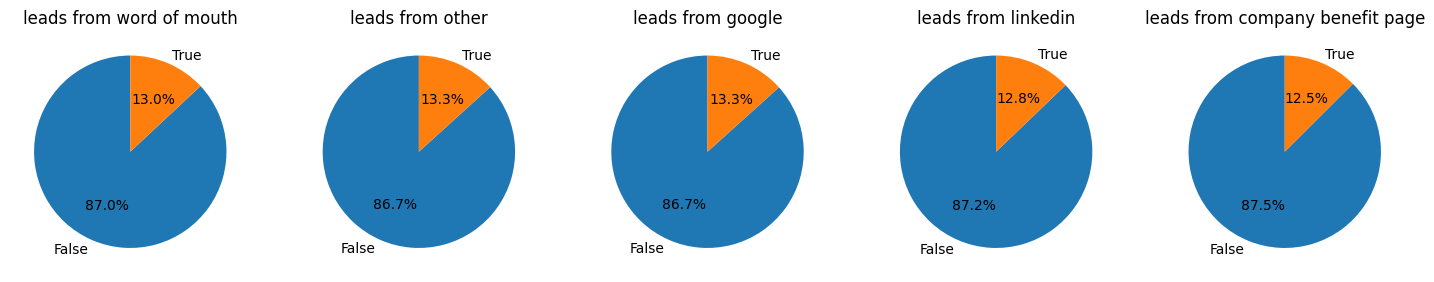

In [27]:
# sales_df['how_did_you_hear_about_us'].value_counts()
# print(unconverted_only['how_did_you_hear_about_us'].value_counts(), ordered_only['how_did_you_hear_about_us'].value_counts())
sources = sales_df['how_did_you_hear_about_us'].unique()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 4))
ax_tuple = (ax1, ax2, ax3, ax4, ax5)

for idx, source in enumerate(sources):
    leads_from_source = sales_df[sales_df['how_did_you_hear_about_us']==source]
    (
        leads_from_source
        .value_counts('has_placed_order')
        .plot(
            kind='pie',
            title='leads from '+source,
            ylabel='',
            autopct='%1.1f%%',
            legend=False,
            shadow=False,
            startangle=90, 
            ax=ax_tuple[idx]
        )
    )

print('conversion rate from source')
plt.show()

# automated exploratory data analysis

In [28]:
from ydata_profiling import ProfileReport
profile = ProfileReport(sales_df, title="profiling report -- oskar holm")

In [29]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 76.38it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
profile.to_file("../notes/eda_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]